# Pytorch手把手進行DCGAN實作，以MNIST資料庫為例

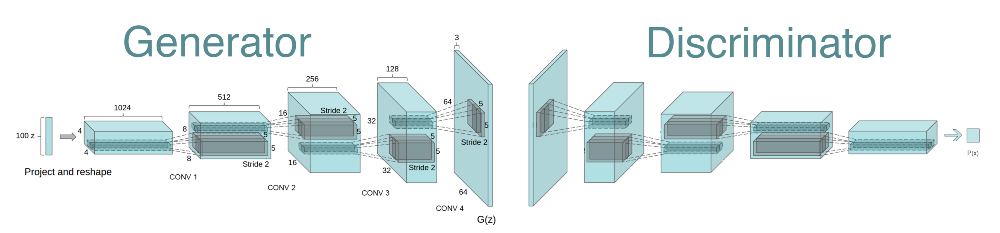


In [1]:
# -*- coding: utf-8 -*-
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import PIL.Image as Image


<font size=4>
    
**Generator** <br><br>
因為我的random vector(z)是採用 latents x 1 x 1 (latents代表z的維度數) <br><br>
DCGAN是採用ConvTranspose2d進行上採樣的進行，也就是讓圖變大張。 <br><br>
MNIST圖片為28 x 28，一般上採樣通常是固定放大1倍。 <br><br>

1 x 1 → 上採樣 → 2 x 2 → 上採樣 → 4 x 4 → 上採樣 → 8 x 8 → 上採樣 → 16 x 16 → 上採樣 → 32 x 32<br><br>
   
所以不會變成28 x 28。<br><br>
    
所以我利用ConvTranspose2d的stride和pad的設計，讓上採樣可以非1倍放大，細節請看程式碼，我每一層輸出的大小有寫在備註。<br>
1 x 1 → ConvTranspose2d → 2 x 2 → ConvTranspose2d → 3 x 3 → ConvTranspose2d → 6 x 6 → ConvTranspose2d → 7 x 7 → ConvTranspose2d → 14 x 14 → ConvTranspose2d → 28 x 28 <br><br>

- ConvTranspose2d : https://blog.csdn.net/qq_27261889/article/details/86304061

In [2]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
        
class CBR(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        norm_layer = nn.BatchNorm2d
        super(CBR, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            norm_layer(out_planes),
            nn.ReLU(inplace=True),
        )
class CBLR(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        norm_layer = nn.BatchNorm2d
        super(CBLR, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            norm_layer(out_planes),
            nn.ReLU(inplace=True),
        )
class TCBR(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=4, stride=2, padding=1):
        padding = (kernel_size - 1) // 2
        norm_layer = nn.BatchNorm2d
        super(TCBR, self).__init__(
            nn.ConvTranspose2d(in_planes, out_planes, kernel_size, stride, padding, bias=False),
            norm_layer(out_planes),
            nn.ReLU(inplace=True),
        )                    
                         
                         

class Generator(nn.Module):
    def __init__(self, latents):
        super(Generator, self).__init__()
        
        self.layer1= nn.Sequential(
            # input is random_Z,  state size. latents x 1 x 1 
            # going into a convolution
            TCBR(latents, 256, 4, 2, 1),  # state size. 256 x 2 x 2
            CBR(256, 128, 3, 1)
        )
        
        self.layer2= nn.Sequential(
            TCBR(128, 256, 4, 1, 0), # state size. 256 x 3 x 3
            TCBR(256, 256, 4, 2, 1), # state size. 256 x 6 x 6
            
        )
        self.layer3= nn.Sequential(
            TCBR(256, 128, 4, 1, 0), # state size. 256 x 7 x 7
            TCBR(128, 128, 4, 2, 1),  # state size. 256 x 14 x 14
            CBR(128, 128, 3, 1)
            # state size. 256 x 6 x 6

        )
        self.layer4= nn.Sequential(
            TCBR(128, 64, 4, 2, 1), # state size. 64 x 28 x 28
            CBR(64, 64, 3, 1),
            CBR(64, 64, 3, 1),
            nn.Conv2d(64, 1, 3, 1, 1), # state size. 1 x 28 x 28
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x
    

class Discriminator(nn.Module):
    def __init__(self,):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            CBLR(1, 32, 3, 2), # b*32*14*14
            CBLR(32, 64, 3, 1), # b*64*14*14
            CBLR(64, 128, 3, 2), # b*128*7*7
            CBLR(128, 128, 3, 2), # b*32*3*3
            CBLR(128, 64, 3, 2), # b*32*1*1
        )        
        self.fc = nn.Linear(64,2)

    def forward(self, x):
        x = self.conv(x)
        x = nn.functional.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1)
        ft = x
        output = self.fc(x)
        return output

In [3]:
# from torchvision.utils import save_image

flag_gpu = 1
# Number of workers for dataloader
workers = 0
# Batch size during training
batch_size = 100
# Number of training epochs
epochs = 20
# Learning rate for optimizers
lr = 0.0002

# GPU
device = 'cuda:0' if (torch.cuda.is_available() & flag_gpu) else 'cpu'
print('GPU State:', device)
# Model
latent_dim = 10
G = Generator(latents=latent_dim).to(device)
D = Discriminator().to(device)
G.apply(weights_init)
D.apply(weights_init)

# Settings
g_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))


g_scheduler = torch.optim.lr_scheduler.StepLR(g_optimizer, step_size=5, gamma=0.5)
d_scheduler = torch.optim.lr_scheduler.StepLR(d_optimizer, step_size=5, gamma=0.5)

# Load data
train_set = datasets.MNIST('E:/Pytorch_DL_Implement/dataset', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=workers)

GPU State: cuda:0


<font size=4> Generator的更新</font>
    
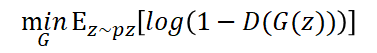

<font size=4> Discriminator的更新</font>
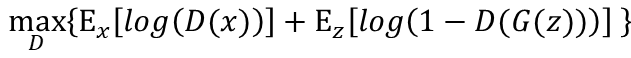

[Epoch: 1/20] D_loss: 0.371 G_loss: 1.235
Generated images for epoch: 1
[Epoch: 2/20] D_loss: 0.184 G_loss: 2.012
Generated images for epoch: 2
[Epoch: 3/20] D_loss: 0.268 G_loss: 1.716
Generated images for epoch: 3
[Epoch: 4/20] D_loss: 0.355 G_loss: 1.426
Generated images for epoch: 4
[Epoch: 5/20] D_loss: 0.405 G_loss: 1.267
Generated images for epoch: 5
[Epoch: 6/20] D_loss: 0.334 G_loss: 1.393
Generated images for epoch: 6
[Epoch: 7/20] D_loss: 0.336 G_loss: 1.421
Generated images for epoch: 7
[Epoch: 8/20] D_loss: 0.334 G_loss: 1.434
Generated images for epoch: 8
[Epoch: 9/20] D_loss: 0.092 G_loss: 2.708
Generated images for epoch: 9
[Epoch: 10/20] D_loss: 0.283 G_loss: 1.671
Generated images for epoch: 10
[Epoch: 11/20] D_loss: 0.325 G_loss: 1.437
Generated images for epoch: 11
[Epoch: 12/20] D_loss: 0.340 G_loss: 1.387
Generated images for epoch: 12
[Epoch: 13/20] D_loss: 0.393 G_loss: 1.284
Generated images for epoch: 13
[Epoch: 14/20] D_loss: 0.410 G_loss: 1.252
Generated ima

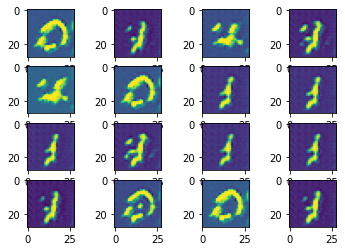

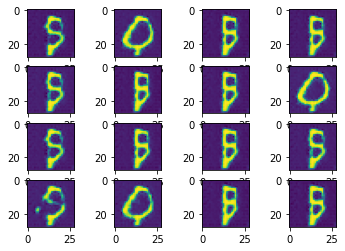

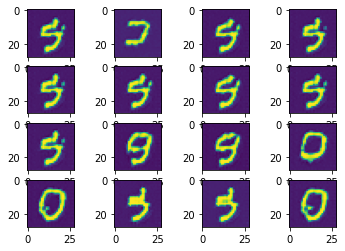

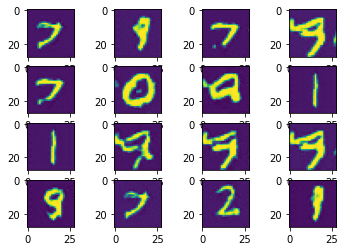

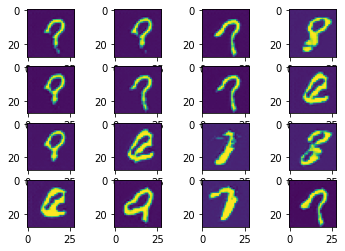

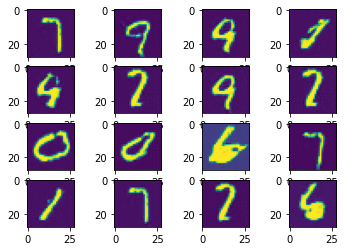

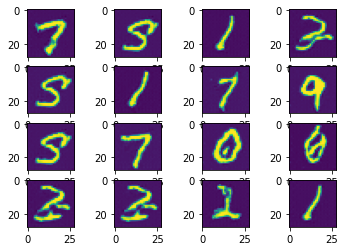

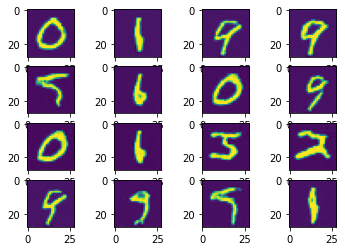

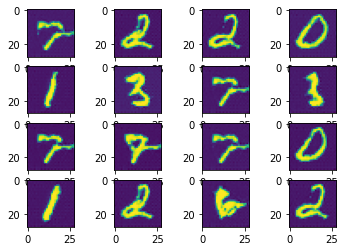

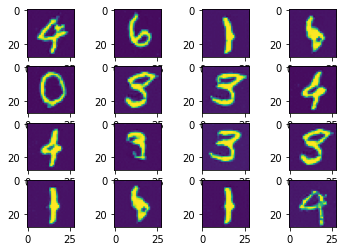

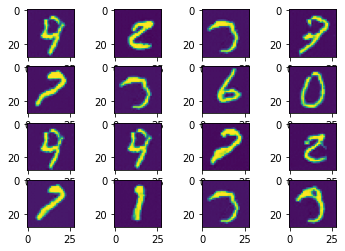

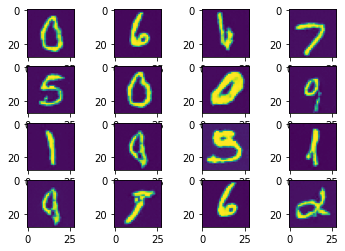

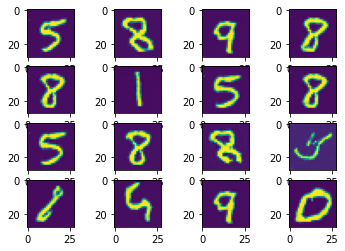

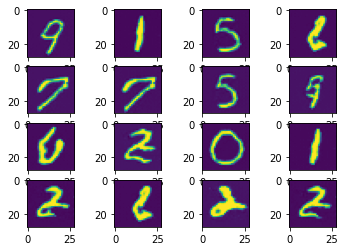

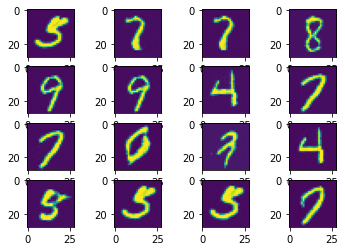

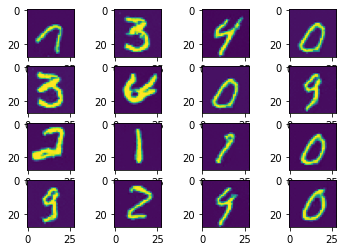

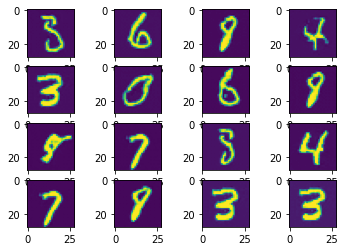

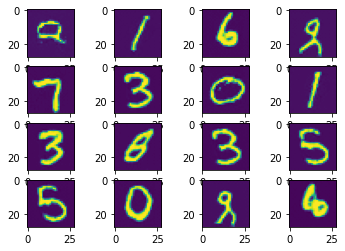

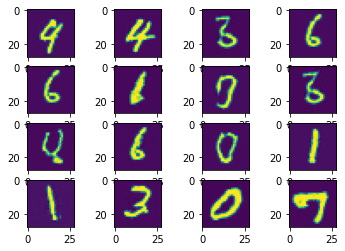

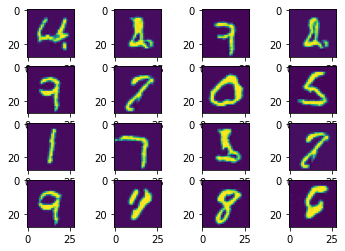

In [4]:
def show_images(images, epoch):
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    plt.figure()
    for index, image in enumerate(images):
        plt.subplot(sqrtn, sqrtn, index+1)
        plt.imshow(image.reshape(28, 28))
    plt.savefig("Generator_epoch_{}.png".format(epoch))
# Train
adversarial_loss = torch.nn.CrossEntropyLoss().to(device)
# adversarial_loss = torch.nn.BCELoss().to(device)

G.train()
D.train()
loss_g, loss_d = [],[]
start_time= time.time()
for epoch in range(epochs):
    epoch += 1
    total_loss_g,total_loss_d=0,0
    count_d=0
    for i_iter, (images, label) in enumerate(train_loader):
        i_iter += 1

        # -----------------
        #  Train Generator
        # -----------------
        g_optimizer.zero_grad()
        # Sample noise as generator input
        noise = torch.randn(images.shape[0], latent_dim, 1, 1)
        noise = noise.to(device)
        
        # 因為Generator希望生成出來的圖片跟真的一樣，所以fake_label標註用 1
        fake_label = torch.ones(images.shape[0], dtype=torch.long).to(device) # notice: label = 1


        # Generate a batch of images
        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        
        # Loss measures generator's ability to fool the discriminator
        loss_g_value = adversarial_loss(fake_outputs, fake_label)
        loss_g_value.backward()
        g_optimizer.step()
        total_loss_g+=loss_g_value
        loss_g.append(loss_g_value) 
        

        # ---------------------
        #  Train Discriminator
        # ---------------------
        # Zero the parameter gradients
        d_optimizer.zero_grad()
        # Measure discriminator's ability to classify real from generated samples
        # 因為Discriminator希望判斷哪些是真的那些是生成的，所以real_label資料標註用 1，fake_label標註用0。
        real_inputs = images.to(device) 
        real_label = torch.ones(real_inputs.shape[0], dtype=torch.long).to(device)
        fake_label = torch.zeros(fake_inputs.shape[0], dtype=torch.long).to(device)
#       learning by Discriminator
        real_loss = adversarial_loss(D(real_inputs),real_label) # 告訴他這是正確的圖片
        fake_loss = adversarial_loss(D(fake_inputs.detach()),fake_label) # 告訴他這是錯誤的圖片

        loss_d_value = (real_loss + fake_loss) / 2
        loss_d_value.backward()
        d_optimizer.step()
        total_loss_d+=loss_d_value
        loss_d.append(loss_d_value)
        
       
    total_loss_g/=len(train_loader)
    total_loss_d/=len(train_loader)
                
    g_scheduler.step()
    d_scheduler.step()
    
    
     

    print('[Epoch: {}/{}] D_loss: {:.3f} G_loss: {:.3f}'.format(epoch, epochs, total_loss_d.item(), total_loss_g.item()))
    if epoch % 1 == 0:
        print('Generated images for epoch: {}'.format(epoch))
        imgs_numpy = fake_inputs.data.cpu().numpy()
        show_images(imgs_numpy[:16],epoch)
#         plt.show()

torch.save(G, 'DCGAN_Generator.pth')
torch.save(D, 'DCGAN_Discriminator.pth')
print('Model saved.')

print('Training Finished.')
print('Cost Time: {}s'.format(time.time()-start_time))

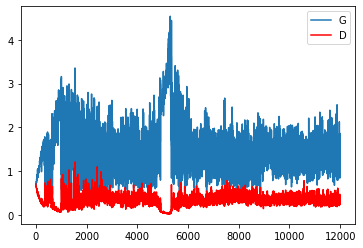

In [5]:
plt.plot(loss_g)
plt.plot(loss_d,'r')
plt.legend(['G','D'])
plt.show()


----------------
## Generator測試


cuda:0


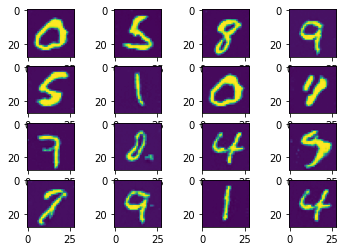

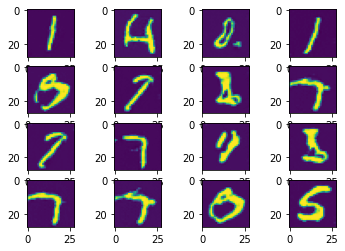

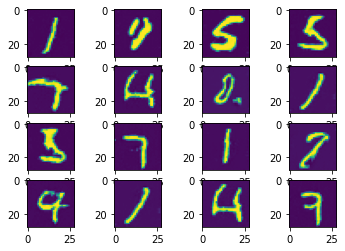

In [6]:
import torch
def show_images(images):
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    plt.figure()
    for index, image in enumerate(images):
        plt.subplot(sqrtn, sqrtn, index+1)
        plt.imshow(image.reshape(28, 28))
    plt.show()

flag_gpu = 1
device = 'cuda:0' if (torch.cuda.is_available() & flag_gpu) else 'cpu'
print(device)

G = torch.load('DCGAN_Generator.pth', map_location=device)
  
latent_dim = 10

## Exp:1
noise = torch.randn(20, latent_dim, 1, 1)
noise = noise.to(device)
        
# Generate a batch of images
fake_inputs = G(noise)
        
imgs_numpy = fake_inputs.data.cpu().numpy()
show_images(imgs_numpy[:16])

## Exp:2
noise = torch.randn(20, latent_dim, 1, 1) *-10000
noise = noise.to(device)
        
# Generate a batch of images
fake_inputs = G(noise)
        
imgs_numpy = fake_inputs.data.cpu().numpy()
show_images(imgs_numpy[:16])


## Exp:3
noise = torch.randn(20, latent_dim, 1, 1) *50000
noise = noise.to(device)
        
# Generate a batch of images
fake_inputs = G(noise)
        
imgs_numpy = fake_inputs.data.cpu().numpy()
show_images(imgs_numpy[:16])